In [52]:
import numpy as np
import pandas as pd


from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc, roc_curve, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib as plt

In [11]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [3]:
train.shape, test.shape

((2834, 6), (7, 4))

In [4]:
train

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845
...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [48]:
train['length'] = [len(i) for i in train['excerpt']]

In [6]:
train.describe()

,target,standard_error,length
count,2834.000000,2834.000000,2834.000000
mean,-0.959319,0.491435,971.732886
std,1.033579,0.034818,117.257578
min,-3.676268,0.000000,669.000000
25%,-1.690320,0.468543,885.000000
50%,-0.912190,0.484721,971.000000
75%,-0.202540,0.506268,1058.000000
max,1.711390,0.649671,1341.000000


<AxesSubplot:xlabel='target', ylabel='length'>

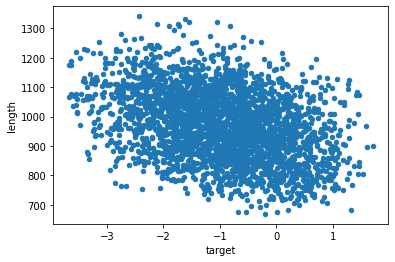

In [7]:
train.plot.scatter('target', 'length')

In [38]:
def tokenize(texts):
    vec = CountVectorizer()
    result = vec.fit_transform(texts)
    vocab = np.array(vec.get_feature_names())
    return [vocab[result[i].indices] for i in range(result.shape[0])]


In [12]:
tokenize(train['excerpt'])

['00',
 '000',
 '000th',
 '001',
 '02',
 '03',
 '034',
 '04',
 '049',
 '06',
 '07',
 '070',
 '090',
 '0v',
 '10',
 '100',
 '1000',
 '100lbs',
 '1011',
 '1012',
 '1016',
 '1024',
 '105',
 '1050',
 '106',
 '108',
 '1095',
 '10am',
 '10th',
 '10x10',
 '10x10½',
 '11',
 '111',
 '112',
 '115',
 '1154',
 '116',
 '11a',
 '11and',
 '11b',
 '11th',
 '12',
 '120',
 '1200',
 '1223',
 '125',
 '127',
 '128',
 '129',
 '1291',
 '1299',
 '12th',
 '12x13',
 '13',
 '130',
 '1305',
 '132',
 '1328',
 '1337',
 '1340',
 '136',
 '1362',
 '1389',
 '13th',
 '13x14',
 '14',
 '140',
 '141',
 '1425',
 '142nd',
 '143',
 '1439',
 '144',
 '1453',
 '148',
 '149',
 '1490s',
 '1492',
 '1496',
 '14th',
 '15',
 '150',
 '1501',
 '1506',
 '1513',
 '1519',
 '1524',
 '1528',
 '1536',
 '1556',
 '156',
 '1580',
 '1585',
 '1592',
 '1598',
 '15th',
 '16',
 '1600',
 '1600s',
 '1607',
 '1608',
 '1610',
 '1613',
 '1615',
 '1624',
 '165',
 '1651',
 '1652',
 '165546',
 '167',
 '1670',
 '1683',
 '1688',
 '1699',
 '16ft',
 '16s',
 '16t

In [40]:
def avgLength(texts):
    wordList = tokenize(texts)
    return [np.mean([len(word) for word in sublist]) for sublist in wordList]

In [41]:
avgLength(["harry potter like dumbledore", "ew"])

[6.25, 2.0]

<AxesSubplot:xlabel='target', ylabel='avgLength'>

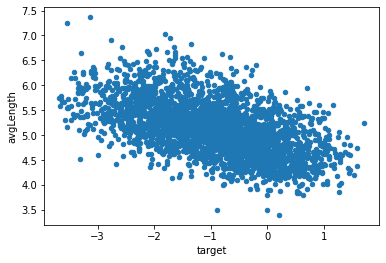

In [43]:
train['avgLength'] = avgLength(train["excerpt"])
train.plot.scatter('target', 'avgLength')

In [50]:
model = LinearRegression()
model.fit(train[["length", "avgLength"]],train["target"])
p = model.predict(train[["length", "avgLength"]])

In [54]:
mean_squared_error(train["target"], p)

0.7427976468081494

In [56]:
test['avgLength'] = avgLength(test["excerpt"])
test['length'] = [len(i) for i in test['excerpt']]
test["prediction"] = model.predict(test[["length", "avgLength"]])
test[["id", "prediction"]].to_csv("/tmp/submission.csv", index=False)